# En biologisk simulering 
14.02.2022

Denne prosjektoppgaven tar utgangspunkt i cellulære membranløse organeller og monomereners rolle i dannelsen av slike. Ved hjelp av numerikk ønsker vi å kunne forutse hvordan monomerene flytter seg slik at vi kan simulere strukturen innad i cellen og hente ut annen viktig informasjon. Vi implementerer en stokastisk simuleringsmetode kalt Monte Carlo for å gjennomføre dette. Metoden setter inn tilfeldige komponenter for hver kjøring som etter tilstrekkelig mange kjøringer vil gi oss et realistisk bilde på hvordan monomerene har lagt seg. Vi får også beregnet energi, gjennomsnittlig størrelse på klynger, størrelse på polymer og annet vi ønsker å vite om vårt biologiske system. I tillegg beregner vi størrelsene ved ulike temperaturer slik at vi får innsikt i hvordan temperaturforskjeller påvirker organellen.

Vi beskriver polymer- og monomersystemene numerisk ved å tilegne de tall, og følger disse gjennom simuleringene. Videre registrerer vi til- og frakoblinger mellom monomerene. Dette gir opphav til energiendringer. For å gi en enklere energiberegning er enkelte forbehold tatt. Interaksjonene er begrenset til å kun påvirke nabomonomeren i systemet, og det vil gjennomgående kun bli tatt hensyn til interaksjoner som oppstår på grunn av monomerenes ladninger. I tillegg ser vi bort fra interaksjoner mellom monomerer innad i samme i polymer. Systemet er også programmert som en torus slik at vi unngår for mange grensebetingelser.

For hver monomer som ligger inntil en annen blir det registrert energi. For monomerer med samme ladning øker systemets energi, og for motsatt ladde monomerer minker energien med tilsvarende verdi. Da systemet streber etter å nå lavest mulig energi vil kun flytt som oppfyller dette eller ikke gir en energiendring realiseres. På grunn av termisk fluksjon vil monomerene fortsatt kunne gjøre et ugunstig flytt. Sannsynlighet for at dette skjer er korrelert med temperaturen og gitt av likningen under. Temperaturen vil derfor spille en avgjørende rolle for hva slags struktur systemet oppnår.

$P = exp(-\frac{1}{k_b \cdot T} \cdot \Delta E)$ $\;\;\;$ (1)
 
I energiplottene vi presenterer er energien skalert med en faktor alfa. Denne er definert sammen med de andre konstanter tidlig i koden, og den får en ny verdi ved koding av polymerer.

I Monte Carlo er det viktig å kjøre koden tilstrekkelig antall ganger slik at systemet når likevekt før data blir hentet ut. Når likevekt er nådd vil systemets verdier fortsatt fluktuere rundt en gjennomsnittlig verdi. For å optimalisere koden hentes ut den gjennomsnittlige verdien ved å fortsette kjørerundene. Vi henter da ut uavhengige stokastiske verdier og tar et gjennomsnitt av disse. Vi sørger for at de er uavhengige ved å vente x antall tidssteg mellom hver verdi vi henter ut. Henter vi ut nok verdier blir approksimeringen god.

Siden koden krever store og mange beregninger har vi importert numba og brukt funksjonen jit for å minimere tiden det tar å kjøre koden. En rekke innebygde funksjoner har derfor blitt styr unna for å få jit til å fungere. Det er også unngått bruken av lister siden numpy arrays kompilerer raskere. Eneste unntak er i generate_grid_of_polymers, men dette er uproblematisk da grid hentes ut utenfor funksjonene. Numba kompilerer fint og ligger derfor på første kodelinje foran funksjoner hvor det var nødvendig. Den eneste funksjon som ikke er kjørt gjennom numba hvor det var ønskelig er den aller siste. Vi har kodet prosjektet i Python, og besvart alle oppgavene.
 

 



In [1]:
# Importerer det som trengs for oppgaven først.
#%pip install numba
import numpy as np
import matplotlib.pyplot as plt
from numba import jit
import numba as nb
import random 
import time

from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import warnings
warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)

In [2]:
#Definerer globale konstanter for senere bruk
a_1 = 23 * 10**-6 #Avstand mellom grid points monomerer (lengden av monomer)
a_2 = 91 * 10**-6 #Avstand mellom grid points polymerer 
e_r = 78 # relativ permittivitet
k_b = 1.38 *10**-23 #stefan boltzmanns konstant
epsilon = 8.85*10**(-12) #permitiviteten i vakuum
e = (1.6*10**(-19)) #elementærladningen
alpha = (e**2/(4*np.pi*epsilon*e_r*a_1**2))  #alpha er en konstant med enhet J, denne bruker a_1
alpha2 = (e**2/(4*np.pi*epsilon*e_r*a_2**2))  #med a_2 i stedet for a_1


## Rutenett med monomerer
I første omgang lager vi et rutenett som fylles med valgfritt antall monomerer. Disse monomerene genereres og plasseres helt tilfeldig på rutenettet. Deretter kan vi plotte de slik at vi kan visulisere det bedre. Det vil være begrensninger ettersom vi bare klarer å se bildet som et kvadrat, i stedet for en torus slik det er i virkeligheten. Likevel vil vi ordne grensebetingelsene slik at systemet oppfører seg som en torus. Dermed vil det bare være begrensninger i visuliseringen, men ikke når vi senere skal regne ut ulike verdier. 

In [3]:
@jit(nopython=True)
def meshgrid(N): #Returnerer et rutenett med bare nullere
    grids = np.zeros((N, N), dtype=np.dtype('i2'))
    return grids

@jit(nopython=True) #Hjelpefunksjon som brukes senere i koden 
def monomer_gridpos(grid_of_monomers):
    return np.argwhere(grid_of_monomers != 0)

In [4]:
@jit(nopython=True)
def generate_grid_of_monomers(M, N): #Lager et rutenett med 2*M monomerer (M positive og M negative), tilfeldig plassert
    summen = 0
    rutenett = meshgrid(N)
    liste = np.zeros(2*M, dtype=np.dtype('i2'))
    while summen < 2*M: #Deler ut monomerer helt til summen har fått verdi lik 2*M
        tall = np.random.randint(1,M+1)*(np.random.randint(0,2)*2-1) #Velger random tall mellom -M og M (utenom null)
        while tall in liste and tall<M: #Om det randome tallet er brukt, øker vi med 1 for å se om det tallet ikek er brukt
            tall += 1 
        if tall not in liste: 
            x, y = np.random.randint(0,N), np.random.randint(0,N) #Gir monomeren en random plassering
            if rutenett[x][y] == 0: #Sjekker om det er noe der fra før
                rutenett[x][y] = tall
                liste[summen] = tall #Legger monomertallet til i listen for å vite hvilke som er brukt 
                summen += 1 #Summen øker kun om en monomer er delt ut
    return rutenett

In [5]:
def plotte(M, N, grid):
    plt.imshow(grid, cmap="BuPu", vmin=-0.5, vmax=0.5)
    plt.title(f"M = {M}, N = {N}")
    plt.rcParams['figure.figsize'] = [8,8]
    plt.show()

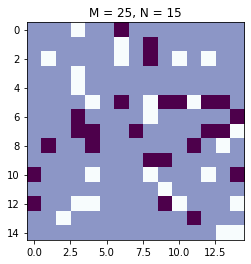

In [6]:
grid = generate_grid_of_monomers(25,15) 
plotte(25,15,grid)

Her ser vi at på det 10x10 rutenettet er det blitt generert 22 tilfeldig plasserte monomerer, hvorav 11 er positive (lilla) og 11 er negative (hvite). 

## Energi

Videre kan det være interessant å se hvor mye energi ulike rutenett gir. Vi vet at dersom to like ladninger ligger inntill hverandre, vil det gi en positiv energi. Motsatt vil to ulike ladninger bidra negativt til energien. Dermed vil ulike rutenett gi ulike verdier for energien. For å regne ut dette vil det være greit å først lage en nabofunksjon som først henter ut alle naboene til et koordinat, denne kan være nyttig i flere ulike sammenhenger. 

In [7]:
@jit(nopython=True)
def naboer(N, i, j):
    point1 = [i-1,j]     #opp
    point2 = [i, j+1]    #høyre
    point3 = [i+1, j]    #ned
    point4 = [i,j-1]     #venstre 
    #Tar hensyn til der vi går utenfor våre indeksnummere siden 
    if i ==0:
        point1 = [N-1, j] 
    if i == N-1:
        point3 = [0, j]
    if j == 0:
        point4 = [i, N-1]
    if j == N-1:
        point2 = [i, 0]
    return np.array([point1, point2, point3, point4])


In [8]:
@jit(nopython=True)
#Endrer tallverdien fra et rutenett slik at alle positive verdier får verdi 1 og alle negative verdier får verdi -1
def value_to_ones(g, N): 
    g=g.copy()
    for i in range(N):
        for j in range(N):
            if g[i][j] > 0:
                g[i][j] = 1
            if g[i][j] < 0:
                g[i][j] = -1
    return g #Kan nå regne ut energi

In [9]:
@jit(nopython=True)
#regner ut energien til et rutenett, men vi regner den ut dimensjonsløst. 
#Energien som returneres er størrelsen E/alpha. 
def energi(M, N, grid):  
    Totalenergi = 0
    ladning = value_to_ones(grid, N) #får ut et nytt rutenett med bare 1 eller -1 (alt etter om de er positive eller negative)
    for i in range(N):
        for j in range(N):
            if ladning[i][j] != 0: #itererer gjennom alle koordinatene i rutenettet og finner alle plassene hvor det er en monomer
                liste = naboer(N, i, j) #henter ut naboene
                for nabo in liste:
                    if ladning[nabo[0]][nabo[1]] != 0: #får kun energi om naboen også er en monomer
                        if ladning[i][j] == ladning[nabo[0]][nabo[1]]: #like ladninger gir positiv energi
                                Totalenergi += 0.5 #Siden vi går gjennom hver rute får de kun 0.5 energi per gang
                        if ladning[i][j] != ladning[nabo[0]][nabo[1]]: #motsatte ladninger gir negativ energi
                                Totalenergi -= 0.5 
    return Totalenergi

Vi kan regne ut energien til rutenettet vi t over, ved hjelp av funksjonen "energi". 

In [10]:
energien = energi(25, 15, grid)

print("Energien til rutenettet er: ", energien)

Energien til rutenettet er:  3.0


## Monte Carlo

Vi ønsker nå å se på hvordan systemet utvikler seg over tid. Vi bruker Monte Carlo. Denne går ut på at monomerene flytter seg tilfeldig i systemet, men alltid har et hovedmål om å oppnå lavest mulig energi. Funksjonen vi lager må dermed plukke ut et tilfeldig polymer og prøve å flytte det til en tilfeldig plass. Om plassen er ledig vil flyttet bare gjennomføres dersom det medfører at systemets energi blir lavere. Det finnes også noen unntak hvor flytt som gir høyere energi vil la seg gjennomføre, som beskrevet innledningsvis. For hver iterasjon oppdateres en liste med energi slik at vi kan plotte resultatene. I tilegg vil rutenettet oppdateres underveis. 



In [11]:
@jit(nopython=True)
def montecarlo(N_s,M,N,T,griden):  #Lager en ny grid der det er gjort et forsøk på å flytte monomerer N_s ganger 
    beta = 1/(k_b * T)
    energiliste = np.zeros(int(N_s), dtype=np.dtype('i2'))
    for i in range(int(N_s)):
        Totalenergi = energi(M, N, griden)
        ranmono = np.random.randint(1,M+1)*(np.random.randint(0,2)*2-1) #Tilfeldig monomer å flytte
        retning = np.random.randint(1,5) #Flytter den i tilfeldig renting
        for s in range(len(griden)):
            for j in range(len(griden)):
                if griden[s][j] == ranmono: 
                    koordinat = [s, j] #Finner koordinaten til monomeren
        new_grid = np.copy(griden)
        s, j = koordinat[0], koordinat[1]
        #randbetingelser:
        if retning == 2 and j == N-1:
            j = -1
        if retning == 3 and s == N-1:
            s = -1
        #flytter monomeren
        if retning == 1 and griden[s-1][j] == 0:
            new_grid[s-1][j] = ranmono
            new_grid[s][j] = 0
        if retning == 2 and griden[s][j+1] == 0:
            new_grid[s][j+1] = ranmono
            new_grid[s][j] = 0
        if retning == 3 and griden[s+1][j] == 0:
            new_grid[s+1][j] = ranmono
            new_grid[s][j] = 0
        if retning == 4 and griden[s][j-1] == 0: 
            new_grid[s][j-1] = ranmono
            new_grid[s][j] = 0
        ny_energi = energi(M, N, new_grid)
        if ny_energi < Totalenergi: #kun om en av disse if-setningene er oppfylt vil den nyegriden tas med videre
            griden = np.copy(new_grid)
            Totalenergi = ny_energi
        elif np.random.random () < np.exp(-beta * alpha*(ny_energi - Totalenergi)):
            griden = np.copy(new_grid)
            Totalenergi = ny_energi
        energiliste[i] = Totalenergi #Energien legges til i listen
    
    return energiliste, griden

In [12]:
@jit(nopython=True)
def hent_energi(N_s, M, N, T_1, T_2, grid): #Henter ut energien som skal plottes
    E_1, G_1 = montecarlo(N_s,M,N,T_1,grid)
    E_2, G_2 = montecarlo(N_s,M,N,T_2,grid)
    return E_1, E_2, G_1, G_2

In [13]:
def plot_energi(E1, E2, G1, G2):
    x = np.arange(0,len(E1),1)
    plt.figure()
    plt.plot(x, E1, label='Energi ved 200 K ')
    plt.plot(x, E2, label='Energi ved 500 K ')
    plt.grid()
    plt.title("Skalert energi ved tempratur 200K og 500K")
    plt.xlabel('MS')
    plt.ylabel('Energi')
    plt.legend()
    fig = plt.gcf()
    fig.set_size_inches(18.5, 7)
    fig.savefig('test2png.png', dpi=100)
    plt.show()

In [78]:
t0 = time.time() #Tid før kjøringen
E1, E2, G1, G2 = hent_energi(50000,25,15,200,500,grid)
t1 = time.time() #Tid etter kjøringen

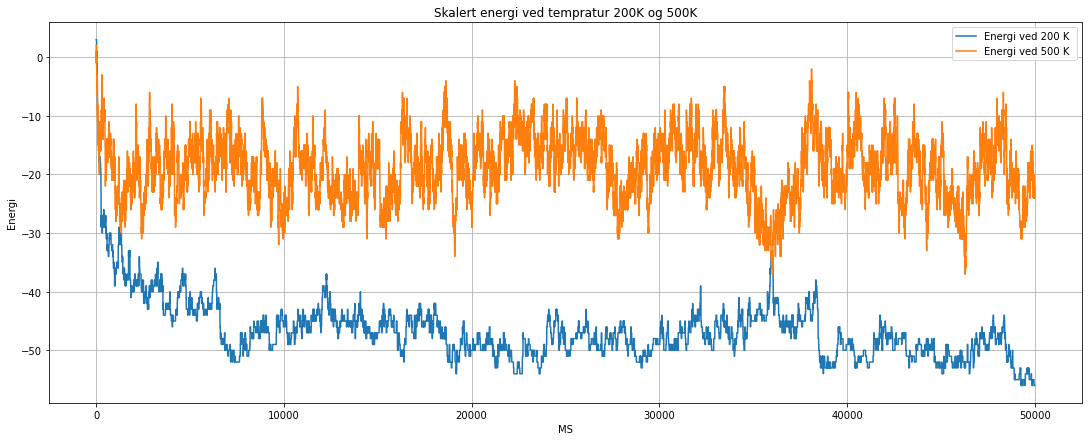

Kjøretid:  203.8777952194214  s


In [77]:
plot_energi(E1, E2, G1, G2)
print("Kjøretid: ", t1 - t0, " s")



Grafene viser energien ved to ulike temperaturer, ved 200 Kelvin og 500 Kelvin. 

Kjøretiden for to Monte Carlo simulasjoner av 50.000 iterasjoner er omtrent 8 sekunder. 

Fra grafen kan vi se at antall tidssteg før likevekt oppnås er forskjellig for de to ulike temperaturene. Dette kan relateres til likning (1). For systemer med lavere temperaturer vil P bli mindre slik at sjansen for at et tilfeldig tall er mindre enn P vil minke. Da er det mindre sannsynlighet for at et monomer flytter seg selv om flyttet ikke er energimessig gunstig. Dette medfører to ting:

1) For høyere temperaturer vil svingningene rundt likevekt være større, siden elif-setningen blir oftere aktivert.

2) Lavere temperatur når en lavere energi.

Ved 500 K vil energien stabilisere seg relativt raskt og kan anslås til rundt tusen iterasjoner - sett med øyemål. Systemet søker seg mot et globalt energi minima men vil foreta seg ugunstige flytt slik at energien ikke blir minimert. Det er som predikert tidligere store variasjoner i energien, og den vil svinge både opp og ned. 

Som vi kan se fra grafen bruker energien litt lengre tid før den stabiliserer seg ved 200 K. Der ser vi at det trengs rundt 10000 iterasjoner. Energien er som forventet også lavere. Grunnen til det har å gjøre med at systemet har lettere for å sette seg fast i lokale energi minima. Det vil si at systemet befinner seg i en tilstand hvor det vil være nødvendig å øke energien litt, for å senere kunne oppnå energi minima. Dersom systemet ikke har nok energi til å gjennomføre disse mellomstegene sier vi at det sitter fast i et lokalt energi minima. Vi ser at en temperatur på 200 K ikke gir nok energi til at monomerene kan flytte så veldig mye på seg. Dermed er det mindre variasjoner i energien ved denne temperaturen. Dette kan også forklare hvorfor det tar lengre tid for systemet å oppnå likevekt. I startfasen vil altså systemet miste mye energi, og sjeldent ta opp energi. Da minker energien totalt, noe vi ser stemmer godt med grafen. Etter en stund vil systemet ha så lav energi at sannsynligheten for å miste energi er tilnærmet sannsynligheten for å ta opp energi, og dermed oppnås likevekt. 


## Klynger av monomerer

Monomerer som ligger inntill hverandre danner tilsammen det vi kan kalle en klynge. Det vil si at det går en sammenhengende "sti" mellom alle monomerene i en klynge (ikke på skrå). Det kan være interessant å se hvordan systemer ved ulike temperaturer vil klynge seg ulikt. 

In [16]:
@jit(nopython=True) #Endrer rutenettet slik at alle monomerene som henger sammen får samme verdi
def cluster_grid(N, monomer_grid): 
    cluster = np.zeros((N, N), dtype=np.dtype('i2'))
    cluster_count = 1
    for i in range(N):
        for j in range(N):
            if monomer_grid[i][j] != 0 and cluster[i][j] == 0:
                cluster[i][j] = cluster_count
                cluster = recursion(monomer_grid, cluster, cluster_count, N, i, j)
                cluster_count +=1 
    return cluster

In [17]:
@jit(nopython=True) 
def recursion(monomer_grid, cluster, cluster_count, N, i, j):
    naboene = naboer(N, i, j)
    for nabo in naboene:
        if cluster[nabo[0]][nabo[1]] == 0 and monomer_grid[nabo[0]][nabo[1]]:
            cluster[nabo[0]][nabo[1]] = cluster_count
            recursion(monomer_grid, cluster, cluster_count, N, nabo[0], nabo[1])
    return cluster

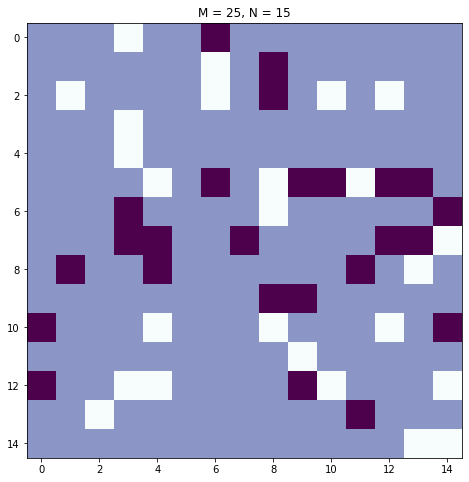

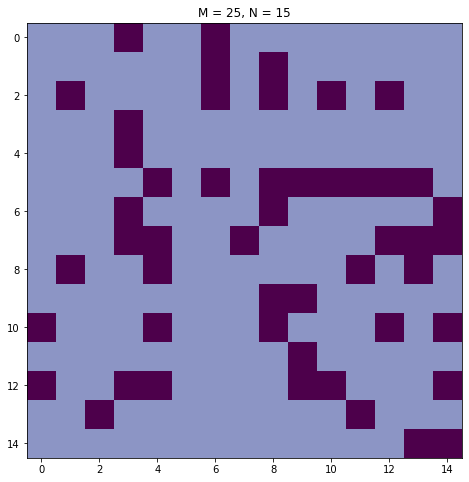

In [18]:
cluster = (cluster_grid(15, grid))
plotte(25,15,grid)
plotte(25,15,cluster)


## Gjennomsnitlig størrelse på klynger

Vi definerer «d» som gjennomsnittlig antall monomere i en klynge. Denne vil variere for ulike temperaturer. For å illustrere dette plottes d for 10 ulike temperaturer. Vi bruker antall steg fra likning (1) som forsikrer oss om at systemet har nådd likevekt før vi henter ut resultatet. Dette gjør at resultatene blir mer realistiske.

In [19]:
Tl, Th, nT = 100, 1000, 10 #ser på 10 ulike temperaturer mellom 100 - 100 K
T_array = np.linspace(Tl, Th, nT)
t_max = 100000 #har satt t_max veldig høy for å oppnå best mulige resultater
s = 1/200
C = 10000


In [20]:
@jit(nopython=True) #antall steg til likvekt kan beskrives ved følgende ligning
def t_equil(T):
    return t_max*np.exp(-s*(T-Tl)) + C


In [21]:
@jit(nopython=True)
def count_monomers_in_clusters(cluster, M, N):
    monpos = np.argwhere(cluster != 0)
    monomerene = np.zeros(len(monpos))
    for s in range(len(monpos)):
        monomerene[s] = cluster[monpos[s][0]][monpos[s][1]]
    monsort = np.sort(monomerene)
    sett = set(monsort)
    return len(monpos)/len(set(monsort))

In [22]:
@jit(nopython=True) #Kjører montecarlo for ulike temperaturer og finner den gjenomsnitlige antall monomerer i en klynge. 
def run_large_scale_montecarlo(n, M, N, T_arr, m_grid):
    dAvg = np.zeros(len(T_arr))
    errArr = np.zeros(len(T_arr))
    for i in range(len(T_array)):# henter ut verdier for hver temperatur
        d = np.zeros(n)
        dSum = 0
        N_s = t_equil(T_arr[i])
        energi, equ_grid = montecarlo(int(N_s),M,N,T_array[i],m_grid)
        for s in range(n): #Henter ut en gjennomsnitlig verdi etter at likevekten i systemet er nådd 
            tr= 1000 #antall tidssteg mellom hver måling
            energi, new_grid = montecarlo(tr,M,N,T_array[i],equ_grid)
            cluster = cluster_grid(N, new_grid)
            d[s] = count_monomers_in_clusters(cluster, M, N)
            dSum += d[s]
            
        dAvg[i] = dSum / n
        err = 0
        for k in range(n):
            err += (d[n] - dAvg[i])**2    #Summerer sammen kvadratet av avviket til hver t_r-te måling.
        errArr[i] = np.sqrt(err/(n-1))    #Bruker summen err til å regne ut standardavviket for <d> for de ulike T
    
    return dAvg, errArr

In [23]:
dAvg, errArr = run_large_scale_montecarlo(10, 25, 15, T_array, grid) 

In [24]:
def plotte_T(d, T_array, error): #plotting av gjennomsnitlig klyngestørrelse per temperatur
    plt.figure()
    plt.title("Tempratur plottet mot gjennomsnittelig d")
    plt.plot(T_array, d, '--')
    plt.errorbar(T_array, d, yerr = error)
    plt.grid()
    plt.xlabel('Temperatur i K')
    plt.ylabel('Gjennomsnittelig antall monomer i hver klynge')
    fig = plt.gcf()
    fig.set_size_inches(18.5, 7)
    fig.savefig('test2png.png', dpi=100)
    plt.show()

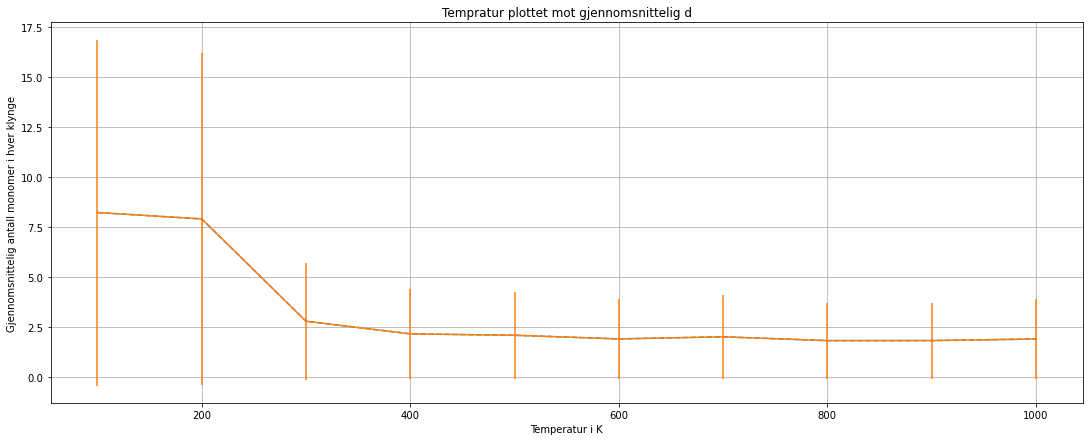

In [25]:
plotte_T(dAvg, T_array, errArr)

Fra tidligere vet vi at lavere temperaturer gir lavere total energi for systemet. Monomerene oppnår lav energi ved å klynge seg sammen i større grupper, slik at gjennomsnittlig størrelse på klyngene vil stige. Jo større temperaturen blir jo mer vil monomerene derimot flytte på seg slik at det i stedet dannes mindre grupper som endres hyppig. Derfor vil høyere temperatur gi mindre klyngestørrelse. 

Vi har valgt n = 30. Dette gir oss en grei gjennomsnittsverdi som kan gi oss realistiske resultater. Det er ikke til å legge skjul på at om vi hadde brukt en større n ville resultatene blitt enda mer nøyaktige. Vi regner med n = 30 gir oss stor nok variasjon i målingene og dermed at de gir en grei tilnærming til sannheten. Likevel er det mulig at vi har uflaks, og at målingene våre ikke var varierte nok. Denne risikofaktoren ser vi på som relativt liten, og konkluderte med at n var stor nok. Dersom vi hadde økt n ville også kjøretiden blitt betydelig lengre, og dermed konkluderte vi med at det ikke var verdt å øke den ettersom den allerede vil gi en god approksimasjon. 

Vi har plottet standardavviket på grafen. Her kan vi tydelig se at standardavviket er størst for lave temperaturer. Dette gir intuitivt mening ettersom det vil være store variasjoner i størrelsen på klyngene for lave temperaturer. Som vi har sett tidligere har systemet lett for å sette seg fast i lokale energi minima, og det vil generelt være mindre bevegelse. Dermed blir det mer tilfeldig hvor store klyngene er når systemet setter seg fast. For høyere temperaturer vil ikke det være et stort problem. Systemet har nok energi til å ikke sette seg fast i disse lokale energi minimumene. Det vil være en mer kontinuerlig bevegelse og når en klynge splittes tar det ikke lang tid før en ny dannes. Dermed vil monomerene klynge seg i mindre grad, og det vil alltid være små grupper av monomerer som henger sammen. På denne måten er heller ikke standardavviket spesielt stort. 

Noe som er litt overraskende er at det kan virke som det finnes en slags kritisk verdi for denne temperaturen. Før en viss temperatur ser vi at standardavviket og klyngestørrelsene er store, men etter denne temperaturen minker de betraktelig. Når de først har gått mye ned holder det seg relativt stabilt.



# Polymerer 

 

Nå kan vi utvide koden vår til å se på sammenhengende monomerer, altså polymerer. 

Vi starter med å definere en funksjon som genererer et NxN koordinatsystem med M polymerer. Hver polymer består av L monomerer. Både fasongen og plasseringen til de ulike polymerene genereres helt tilfeldig i koden vår. 


In [26]:
#Henter et tilfeldig koordinat for den neste monomeren som skal plasseres ut. (hjelpefunksjon)
def get_random_coord(N, liste_med_plasserte_mon, rutenett):
    koord = random.choice(liste_med_plasserte_mon)
    naboene = naboer(N, koord[0], koord[1])
    new_koord = random.choice(naboene)
    return new_koord[0], new_koord[1]

In [27]:
#Funksjon som genererer et gridsystem av størrelse NxN, med 2*M polymerer av størrelse L
def generate_grid_of_polymers(L, M, N):
    L = L-1
    #N = N
    summen = 0
    rutenett = meshgrid(N)
    liste = np.linspace(-M, M, 2*M+1)
    liste = liste[liste != 0]
    for i in range(len(liste)):
        summen = 0
        while summen ==0:
            liste_med_plasserte_mon = ([])
            tall = liste[i]
            x, y = int(np.random.randint(0,N)), int(np.random.randint(0,N)) #tilfeldige koordinater
            liste_med_plasserte_mon.append([x, y])   #legger denne koordinaten til i listen over utplasserte monomerer
            if rutenett[y][x] == 0: #dersom ledig plass, fortsetter vi
                rutenett_new = rutenett.copy() #Lager nytt rutenett som vi kun bruker om alt går bra
                rutenett_new[y][x] = tall #Plaserer et monomer
                tall_nabo, maxgrense = 0, 0
                while tall_nabo < L and maxgrense <500: #Fortsetter til L antall er satt ut
                    x_nabo, y_nabo = get_random_coord(N, liste_med_plasserte_mon, rutenett)
                    maxgrense += 1 #Har en maksgrense i tilfelle vi prøver å sette polymer et sted det ikke er nok plass
                    if rutenett_new[int(y_nabo)][int(x_nabo)] == 0: #Hvis naboen er ledig
                        rutenett_new[int(y_nabo)][int(x_nabo)] = tall #Så plasser et monomer
                        liste_med_plasserte_mon.append([x_nabo, y_nabo])
                        tall_nabo +=1
                if maxgrense != 500 and tall_nabo == L: #Hvis riktig antall L er plassert ut
                    summen += 1
                    rutenett = rutenett_new.copy() #Rutenettet tas i bruk
    return rutenett

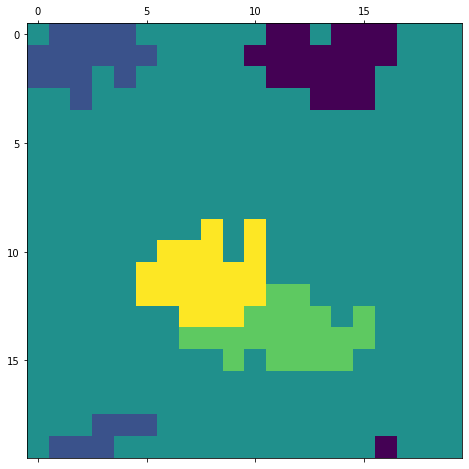

In [82]:
#Funksjon som plotter polymerer med farger
def plotte_poly(M, N, grid):
    fig, ax = plt.subplots()
    min_val, max_val = -M, M
    ax.matshow(grid)#, cmap=plt.cm.Blues)
    plt.rcParams['figure.figsize'] = [8,8]
    
#Plotter et system med L>20
polymerer = generate_grid_of_polymers(21, 2, 20)
plotte_poly(2, 21, polymerer)

## Energi for et system av polymerer

Videre vil vi se på energien til systemer av polymerer. Dette vil bli nyttig senere i koden når vi skal se på ulike temperaturer og klyngestørrelser, og vi kan bruke energien til å forklare mye av det som skjer. 

In [29]:
@jit(nopython=True)
def energi2(N, grid):
    totalenergi = 0
    for i in range(N):
        for j in range(N):
            if grid[i][j] != 0:
                naboene = naboer(N, i, j)
                for nabo in naboene:
                    verdinabo = grid[nabo[0]][nabo[1]]
                    if grid[i][j] != verdinabo:
                        if grid[i][j]*verdinabo<0:
                            totalenergi += -0.5
                        elif grid[i][j]*verdinabo>0:
                            totalenergi += 0.5
    return totalenergi

### Statisk forflytning

Det er ulike måter et polymer kan flytte på seg. Å programmere et veldig realistisk flytteprogram vil bli meget vanskelig. Derfor skal vi videre gjøre ulike forenklinger for forflytningene. Først skal vi se på flytt som bare gjennomføres dersom det er plass til at hele polymeret kan flytte seg (statisk forflytning, eller "rigid move"). Det vil derfor være nødvendig å ha en hjelpefunksjoner som sjekker om et flytt er lovlig. Dersom det ikke er noen andre polymerer i veien, vil flytte la seg gjøre basert på de samme betingelsene som vi så på for monomerene. Altså den flytter seg om det er energimessig gunstig, eller hvis tilfeldighetene tillater det. 

In [30]:
@jit(nopython=True) #flytter polymeret om det er lovlig
def move_polymer(L, M, N, polymer_number, retning, grid_of_monomers):
    copygrid = np.copy(grid_of_monomers)
    hjelpearray = np.array([0,1,2,3,0,1]) 
    bak = hjelpearray[retning + 2]
    
    if allowed_move(N, polymer_number, retning, grid_of_monomers):
        for i in range(N):
            for j in range(N):
                naboene = naboer(N, i, j)
                nabo, nabobak = naboene[retning], naboene[bak]
                if grid_of_monomers[i][j] == polymer_number and (grid_of_monomers[nabo[0], nabo[1]] == 0 or grid_of_monomers[nabo[0], nabo[1]] == polymer_number):
        
                    copygrid[i][j] = 0
                    copygrid[nabo[0]][nabo[1]] = polymer_number
                    if grid_of_monomers[nabobak[0]][nabobak[1]]== polymer_number:
                        copygrid[i][j] = polymer_number
    return copygrid

In [31]:
#Sjekker om rutene som polymerern ønsker å flytte til enten er tomme eller en del av polymeren.
@jit(nopython=True)
def allowed_move(N, polymer_number, retning, grid_of_monomers):
    totalverdi = 0
    for i in range(N):
        for j in range(N):
            nabo = naboer(N, i, j)[retning]
            if grid_of_monomers[i, j]==polymer_number:
                naboverdi = grid_of_monomers[nabo[0], nabo[1]]
                if naboverdi == 0 or naboverdi== polymer_number:
                    totalverdi +=0
                else:
                    totalverdi +=1
    if totalverdi==0:
        return True
    else:
        return False

## Monte Carlo Polymer

Vil nå gjennomføre den samme metoden som vi brukte for monomerer. Da regnes altså energien ut etter hvert som tiden går. Tilsammen skal vi gjennomføre 30.000 iterasjoner og se hvordan rutenettet vil endre seg fra start til slutt. 

In [32]:
@jit(nopython=True)
def montecarlo_polymer(N_s,L, M,N,T,griden):  #Lager en ny grid der det er gjort et forsøk på å flytte monomerer N_s ganger 
    beta = 1/(k_b * T)
    energiliste = np.zeros(int(N_s), dtype=np.dtype('i2'))
    Totalenergi = energi2(N, griden)
    
    for i in range(int(N_s)):
        ranpoly = np.random.randint(1,M+1)*(np.random.randint(0,2)*2-1) #Tilfeldig monomer å flytte
        retning = np.random.randint(0,4) #Flytter den i tilfeldig renting
        antall_flytt = 0

        if allowed_move(N, ranpoly, retning, griden): #flytter kun om det er lovlig
            new_grid = griden.copy()
            new_grid = move_polymer(L, M, N, ranpoly, retning, new_grid)
            ny_energi = energi2(N, new_grid)
            if ny_energi < Totalenergi: 
                griden = new_grid.copy()
                Totalenergi = ny_energi
            if np.random.random()  < np.exp(-beta * alpha2 * (ny_energi - Totalenergi)):
                griden = new_grid.copy()
                Totalenergi = ny_energi
        energiliste[i] = Totalenergi
        
    return energiliste, griden


In [33]:
Ld, Md, Nd = 12, 5, 20 #betingelser for denne kjøringen
N_sd = 30000
Td = 200
polygrid = generate_grid_of_polymers(Ld, Md, Nd)

Kjører 30000 iterasjoner av dette gridsystemet gjennom Monte Carlo-simulasjonen.
Polymerene har ikke endret fasong, fordi vi har flyttet de med rigide flytt. 

In [34]:
t0 = time.time() #tid før kjøring av monte carlo
energi, movedgrid = montecarlo_polymer(N_sd,Ld, Md,Nd,Td,polygrid)
t1 = time.time() #tid etter kjøring av monte carlo

Rutenett før forflytning: 


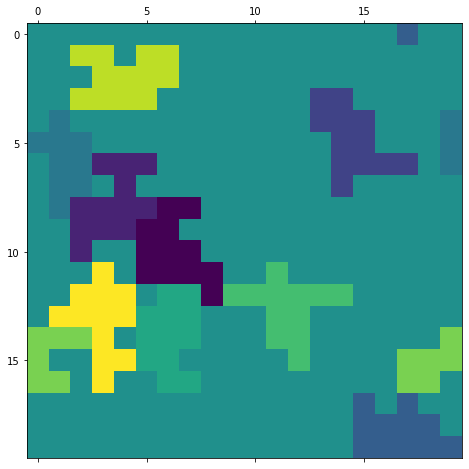

In [35]:
print("Rutenett før forflytning: ")
plotte_poly(Md, Nd, polygrid) #originalt plott

Rutenett etter forflytning: 


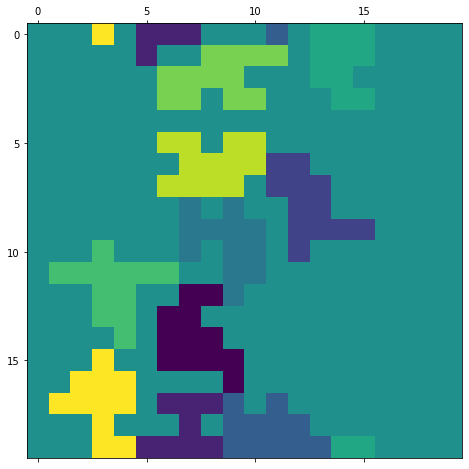

In [36]:
print("Rutenett etter forflytning: ")
plotte_poly(Md, Nd, movedgrid) #plott etter forflytning

In [37]:
print('Kjøretid: ', t1 - t0)

Kjøretid:  24.14465570449829


Kjøretiden for en Monte Carlo simulasjon av 30.000 iterasjoner er omtrent 24 sekunder.

Vi ser at Monte Carlo har en kjøretid som er betydelig høyere for forflyttning av polymerer enn monomerer. Dette kan relateres til at vi for hver iterasjon ønsker å flytte samt sjekke L antall monomerer, og plassere sammenlignet med én tidligere. Da vil tiden øke. 
Det kan forventes at tiden økes med litt mindre enn et multiplum av L. Dette er fordi vi nå gjør nesten hver kodelinje L ganger. Grunnen til at det vil ta noe mindre tid er fordi enkelte prosesser er like for både ett monomer og flere - med andre ord uavhengig av L. Eksempelvis å kopiere over det nye rutenettet eller kalkulere energien til systemet.

For å sammenligne kjøretiden med tidligere monomerene fra tidligere har vi kjørt Monte Carlo-simulasjonen med 50.000 iterasjoner også. Dette ga en kjøretid på omtrent 40 sekunder. Sammenliknet med Monte Carlo-simulasjonen for monomerene, er dette 10 ganger lengre kjøretid. Dette er som forventet.


### Delvis forflytning (Medium flexible move)

Nå skal vi rettet blikket mot en annen type forflytning. Dette er en modell som er litt mer fleksibel, og godtar litt flere ulike typer flytt. Det vil ikke lengre være nødvendig at det må være plass til at hele polymeret kan flytte seg, for at et flytt skal kunne skje. Dersom deler av polymeret kan flytte seg, vil dette skje. Det er likevel noen unntak. For eksempel hvis en rad/kolonne mister sin struktur (altså "hull" på rader tettes) vil ikke dette la seg gjennomføre. Dersom det ikke er plass til at en enkelt rad/kolonne flytter seg, vil denne bare bli stående. Det må likevel tas hensyn til at polymerene kan bli ødelagt, og dette skal ikke tillates. Derfor lager vi hjelpfunksjoner som forhindrer dette. 

In [38]:
#Funksjoner som sjekker om polymer nummer m er ødelagt.
@jit(nopython=True)
def broken_recursion(grid_of_polymers, broken_test, m, N, i, j, l):
    naboene = naboer(N, i, j)
    for nabo in naboene:
        if broken_test[nabo[0]][nabo[1]] != 0 and grid_of_polymers[nabo[0]][nabo[1]] == m:
            l+=1
            broken_test[nabo[0]][nabo[1]] = 0
            l, broken_test = broken_recursion(grid_of_polymers, broken_test, m, N, nabo[0], nabo[1], l)
    
    return l, broken_test

In [39]:
@jit(nopython=True) #sjekker om et polymer blir ødelagt 
def broken_poly(grid_of_polymers, L, m, N):
    broken_test = np.copy(grid_of_polymers)
    mon_pos = np.argwhere(grid_of_polymers == m)
    m = broken_test[mon_pos[0][0]][mon_pos[0][1]]
    broken_test[mon_pos[0][0]][mon_pos[0][1]] = 0
    l, broken_test = broken_recursion(grid_of_polymers, broken_test, m, N, mon_pos[0][0],mon_pos[0][1], 1)
    if l != L:
        return True
    else:
        return False

In [40]:
@jit(nopython=True)
def change_rownumber(L, M, N, polymer_number, retning, grid_of_monomers, monomer_pos):
    if retning == 1 or retning == 3:    #Da kommer flyttet til å være horisontalt. Dette gjør at jeg kan flytte en rad. 
        moved = np.copy(grid_of_monomers)   #Kopierer den gamle. 
        for i in range(len(monomer_pos)):
            if grid_of_monomers[monomer_pos[i][0]][monomer_pos[i][1]] == polymer_number:  #Endrer slik at alle monomerene på samme rad i et polymer får samme verdi 
                for k in range(N):
                    if monomer_pos[i][0] == k:
                        moved[monomer_pos[i][0]][monomer_pos[i][1]] = M+k+1
                
    if retning == 0 or retning == 2:
        moved = np.copy(grid_of_monomers).T    #Må transponere en del frem og tilbake for at det skal bli riktig med denne inputen.
        for i in range(len(monomer_pos)):
            if moved.T[monomer_pos[i][0]][monomer_pos[i][1]] == polymer_number:  #Endrer slik at alle monomerene på samme rad i et polymer får samme verdi 
                for k in range(N):
                        if monomer_pos[i][1] == k:
                            moved.T[monomer_pos[i][0]][monomer_pos[i][1]] = M+k+1
        moved = moved.T
    return moved


In [41]:
@jit(nopython=True)
def med_flex_move(L, M, N,polymer_number, retning, grid_of_polymers):
#Prøver at alle monomerer i et polymer flyttes i samme horisontale eller vertikale retning
#If noen av disse monomerene kræsjer med en monomer i et annet polymer, 
#blir hele raden eller kolonnen som monomeren er en del av stående. 
#Kollisjonsfrie rader eller kolonner blir forflyttet.
    if allowed_move(N, polymer_number, retning, grid_of_polymers):   #dersom hele polymeren kan flytte som vanlig gjør den bare det.
        moved = move_polymer(L, M, N, polymer_number, retning, grid_of_polymers)
    else: 
        monomer_pos = monomer_gridpos(grid_of_polymers) #Henter posisjonen til alle monomerene. Sjekker deretter om verdien er polymer_number
        moved = change_rownumber(L, M, N, polymer_number, retning, grid_of_polymers, monomer_pos)
        for p in range(N+1):
            moved = move_polymer(L, M, N, M+p+1, retning, moved)
    for l in range(N):
        for m in range(N):
            if moved[l][m] in range(M+1, M+N+2):
                moved[l][m] = polymer_number
    if broken_poly(moved, L, polymer_number, N):
        return grid_of_polymers
    else:
        return moved

In [42]:
@jit(nopython=True)
def montecarlo_polymer_flex(N_s,L, M,N,T,griden):  #Lager en ny grid der det er gjort et forsøk på å flytte monomerer N_s ganger 
    beta = 1/(k_b * T)
    energiliste = np.zeros(int(N_s), dtype=np.dtype('i2'))
    Totalenergi = energi2(N, griden)
    
    for i in range(int(N_s)):
        ranpoly = np.random.randint(1,M+1)*(np.random.randint(0,2)*2-1) #Tilfeldig monomer å flytte
        retning = np.random.randint(0,4) 
        antall_flytt = 0
        new_grid = griden.copy()
        new_grid = med_flex_move(L, M, N, ranpoly, retning, new_grid)
        ny_energi = energi2(N, new_grid)
        if ny_energi < Totalenergi: #samme betingelser som før
            griden = new_grid.copy()
            Totalenergi = ny_energi 
        if np.random.random()  < np.exp(-beta * alpha2 * (ny_energi - Totalenergi)):
            griden = new_grid.copy()
            Totalenergi = ny_energi
        energiliste[i] = Totalenergi
        
    return energiliste, griden

In [43]:
t0 = time.time() #tid før kjøring
e, g = montecarlo_polymer_flex(30000,Ld, Md,Nd,Td,polygrid)
t1 = time.time() #tid etter kjøring

Kjøretid:  203.8777952194214


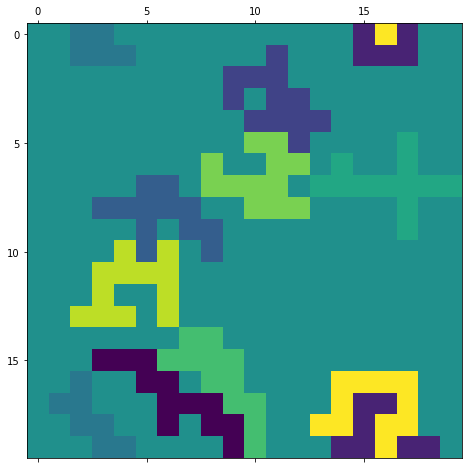

In [44]:
plotte_poly(Md, Nd, g)
print("Kjøretid: ", t1-t0)

Kjøretid etter 30.000 iterasjoner: 

In [45]:
@jit(nopython=True)
def hent_energi_poly(N_s, L, M, N, T, grid):
    E_1, G_1 = montecarlo_polymer(N_s, L, M, N, T, grid)
    E_2, G_2 = montecarlo_polymer_flex(N_s, L, M, N, T, grid)
    return E_1, E_2, G_1, G_2


def plot_energi2_poly(E1, E2, G1, G2):
    x = np.arange(0,len(E1),1)
    plt.figure()
    plt.plot(x, E1, label='Energi ved "rigid move"')
    plt.plot(x, E2, label='Energi ved "medium flexibility move"')
    plt.grid()
    plt.title("Energi ved ulike forflytnings tillatelser")
    plt.xlabel('MS')
    plt.ylabel('Energi')
    fig = plt.gcf()
    fig.set_size_inches(18.5, 7)
    fig.savefig('test2png.png', dpi=100)
    plt.legend()
    plt.show()

In [46]:
E1_p, E2_p, G1_p, G2_p = hent_energi_poly(30000,Ld, Md,Nd,Td,polygrid)

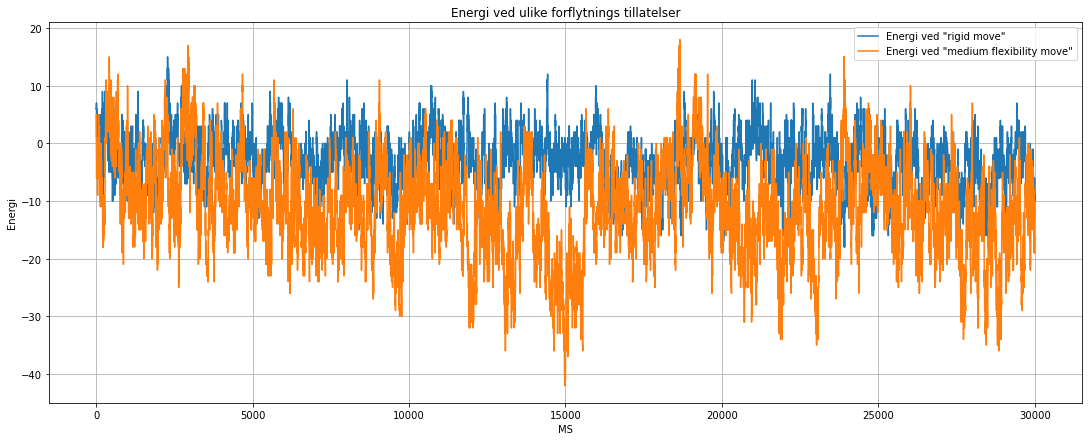

In [47]:
plot_energi2_poly(E1_p, E2_p, G1_p, G2_p)

Vi har her plottet energien for systemet vårt med de to ulike forflytningsbetingelsene. Vi ser at den statiske forflyttningsmetoden gir et system i høyere energi enn den delvise. Dette kan forklares med at den delvise forflytninger får polymerene nærmere hverandre. Siden de er nærmere hverandre vil lavere energi bli registrert. Ved den statiske forflytningen vil derimot polymerene kun ligge tett inntil hverandre som de” passer inn i hverandre” fra før, siden formen ikke kan endres under flyttingen. Dette er mindre sannsynlig at skjer.

Samtidig vil delvis forflytning variere mer. Dette er fordi et flytt potensielt sett flytter flere monomerer fra hverandre, og vil endre energien mer drastisk enn om polymerene ikke lå helt inntil hverandre. 

Selv polymerene nå kan flyttes mer fritt er det viktig å påpeke at forflytningen fortsatt ikke er optimalisert. Ideelt hadde vi ønsket å implementere mulighet for å «tviste» polymerene slik at de i mindre grad stagnerer når de kommer nærme hverandre. Begrensningen gir oss derimot mindre kompleksitet i koden og en mer håndterlig kjøretid.
 
Siden polymerene hadde ligget mer tett ved et mer fleksibelt flytt ville dette trolig gitt noe lavere energi. Det kan være greit å ha i bakhodet da dette i større grad vil gjenspeile virkeligheten.

## Klyngestørrelse og klyngeantall per multivalens

Noe annet interessant å se på er hvordan klyngestørrelsen og antallet klynger vil variere som funksjon av L. Vi bruker delvis forflytnings funksjonen som utgangspunkt for forflytningene. 


In [48]:
L_liste = np.linspace(3, 39, num = 13) 

In [110]:
def plot_energi2_poly(m, merr, d, derr, Larr):
    x = Larr
    plt.figure()
    plt.plot(x, m)
    plt.errorbar(x, m, yerr = merr, label="Gjennomsnittlig antall klynger, med standardavvik")
    plt.plot(x, d)
    plt.errorbar(x, d, yerr = derr, label='Gjennomsnittlig antall polymerer i hver klynge, med standardavvik"')
    plt.grid()
    plt.title("Mean value plottet ved ulike L, T = 300, N = 30 og M = 5")
    plt.xlabel('L')
    plt.ylabel('Antall')
    plt.legend()
    plt.show()

In [106]:
N = 30
M = 5
n=10
T=300
grid0er = np.zeros((len(L_liste), N, N ))
for i in range(len(L_liste)):
    grid0er[i] = generate_grid_of_polymers(L_liste[i], M, N)


#@jit(nopython=True)
def m(cluster):
    monpos = np.argwhere(cluster != 0)
    monomerene = np.zeros(len(monpos))
    for s in range(len(monpos)):
        monomerene[s] = cluster[monpos[s][0]][monpos[s][1]]
    monsort = np.sort(monomerene)
    sett = set(monsort)
    return len(set(monsort))

#@jit(nopython=True)
def oppgave_h(L_liste, M, N, T, gridarr, n):
    N_s = 100
    dAvg = np.zeros(len(L_liste), dtype=np.dtype('f'))
    
    d_liste = np.zeros(len(L_liste), dtype=np.dtype('f'))
    m_liste = np.zeros(len(L_liste), dtype=np.dtype('f'))
    
    derrArr = np.zeros(len(L_liste), dtype=np.dtype('f'))
    merrArr = np.zeros(len(L_liste), dtype=np.dtype('f'))
    
    for l in range(len(gridarr)):
        d = np.zeros(n, dtype=np.dtype('f'))
        m = np.zeros(n, dtype=np.dtype('f'))
        dSum = 0
        mSum = 0
        
        e, equ_grid = montecarlo_polymer_flex(N_s,L_liste[l], M,N,T,gridarr[l])
        
        for s in range(n): #Henter ut en gjennomsnitlig verdi etter at likevekten i systemet er nådd 
            tr= 1000 #antall tidssteg mellom hver måling
            energi, equ_grid = montecarlo_polymer_flex(N_s,L_liste[l], M,N,T,equ_grid)
            
            
            c_grid = cluster_grid(N, equ_grid)
            d[s] = count_monomers_in_clusters(c_grid, M, N)/L_liste[l] #antall polymerer i hver kluster
            m[s] = len(np.unique(c_grid))-1    #Dette vil da være antall
            dSum += d[s]
            mSum += m[s]
        
        d_liste[l] = dSum/n 
        m_liste[l] = mSum/n
        derr = 0
        merr = 0
        
        for k in range(n):
            derr += (d[k] - d_liste[i])**2    #Summerer sammen kvadratet av avviket til hver t_r-te måling.
            merr += (m[k] - m_liste[i])**2    #Summerer sammen kvadratet av avviket til hver t_r-te måling.
        derrArr[l] = np.sqrt(derr/(n-1))    #Bruker summen err til å regne ut standardavviket for <d> for de ulike T
        merrArr[l] = np.sqrt(merr/(n-1))
        
    return d_liste, m_liste, derrArr, merrArr

d_liste, m_liste, derrArr, merrArr = oppgave_h(L_liste, M, N, T, grid0er, 10)


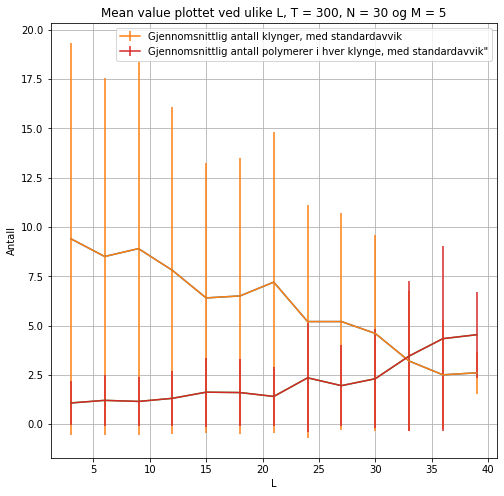

In [111]:
plot_energi2_poly(m_liste, merrArr, d_liste, derrArr, L_liste)


Her har vi brukt delvis forflytning, men dersom vi hadde brukt statisk forflytning (rigid move) i stedet for delvis forflytning ville det muligens gitt flere klynger. Grunnen til dette er at når hele polymeret flytter seg samtidig vil det være store sjanser for at det er noe i veien for minst en av radene/kolonnene. Dermed er det mindre sannsynlig at flyttet skjer i utgangspunktet, og klyngene vil ikke kunne vokse. Med delvis forflytning holder det at minst en av radene/kolonnene har mulighet til å komme i kontakt med andre klynger. Dermed vil vi tro at klyngestørrelsen hadde gått ned ved statisk forflytning. 

Vi har som tidligere valg en n som gir rimelig kjøretid men som samtidig henter ut et godt gjennomsnitt. For større L blir det mindre plass å flytte seg på og klyngestørrelsene vil øke. For få L vil derimot polymerene vandre langt bort fra hverandre og klyngene vil forbli mindre. 

Vi ser at standardavviket minker for høyere L. Dette kan forklares. For høyere L vil et flytt av et polynom bort fra en klynge gi større innvirkning på gjennomsnittlig klyngestørrelse enn om polynomet var lite. På samme vis vil et stort polynom som kobler seg på en klynge gjøre at klyngestørrelsen øker betydelig. Derfor vil høyere L gi økt variasjon i resultater.

Det kan diskuteres hva som vil skje hvis vi endrer på andre parametere enn L. Vi kan for eksempel endre på N. Vi ser at dersom vi øker N, vil rutenettet bli større. Det vil da altså bli bedre plass til polymerene og de vil ikke klynge seg i like stor grad. Dermed vil energien bli større. Tilsvarende omvendt om vi minker N vil polymerene ligge tettere, og de vil klynge seg mer. Det kan også være interessant å se hva som skjer om vi endrer på M. Et større tall for M gjør også at polymerene vil ligge tettere, og klynge seg mer. Et mindre tall for M gjør motsatt og de vil klynge seg mindre. Dette gir også intuitivt mening ettersom det blir mer/mindre plass per polymer. 

Vi skulle gjerne kjørt denne koden med høyere iterasjoner, nærmere likevekt, men siden vi ikke har fått koden til å kompilere med numba, så vi oss nødt til å senke antall iterasjoner. Dette gir et mer upresist resultat, men vi kan allikevel se en trend. 

## Avslutning

Monte Carlo har vist seg å fungere som en god simuleringsmetode for de problemstillingene vi har møtt på, og vi har fått grafer som stemmer overens med forventede resultater. Det er tydelig at temperaturen spiller en avgjørende rolle for hvordan systemet blir seende ut. For lavere temperaturer vil energien i større grad minimeres mens systemet bruker noe lengere tid på å nå likevekt. Prosjektet demonstrerer også hvordan to ganske så forskjellige grener innenfor naturvitenskap kan møtes og ta utnytte av hverandre, her biologien og matematikken.








Avslutningsvis er det verdt å nevne at vår energi siden prosjektstart nå har falt noe. Muligens er det et lokalt energiminimum, som øker seg til neste prosjekt.

